In [1]:
import pandas as pd
import numpy as np
import lib_tools as pt # Project Tools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import date, datetime

start_year = 2005      # Année de début de période d'étude
end_year   = 2021      # Année de fin de période d'étude   
chk        = False     # Affichage de log des checks
sampled    = False      # Travail sur données samplées de df

df, dic_usagers, dic_caract, dic_lieux, dic_vehic = pt.get_work_df(start_year, end_year, sampled, chk)

In [2]:
display_stat_data_load = False

if display_stat_data_load:
    pt.display_stats_data_load(dic_usagers, dic_caract, dic_lieux, dic_vehic, start_year, end_year)

### Suppression des colonnes jugées non pertinentes

In [3]:
# relatives à une info géographique trop fine
cols_rmv = ['com', 'adr', 'lat', 'long', 'pr', 'pr1']
df = df.drop(columns=cols_rmv, axis=1)

# non connue en pratique avant l'accident
cols_rmv = ['obs', 'obsm', 'choc', 'manv']
df = df.drop(columns=cols_rmv, axis=1)

### Représentation graphique des *Null* - Suppression de variables avec plus de 8 % de Null

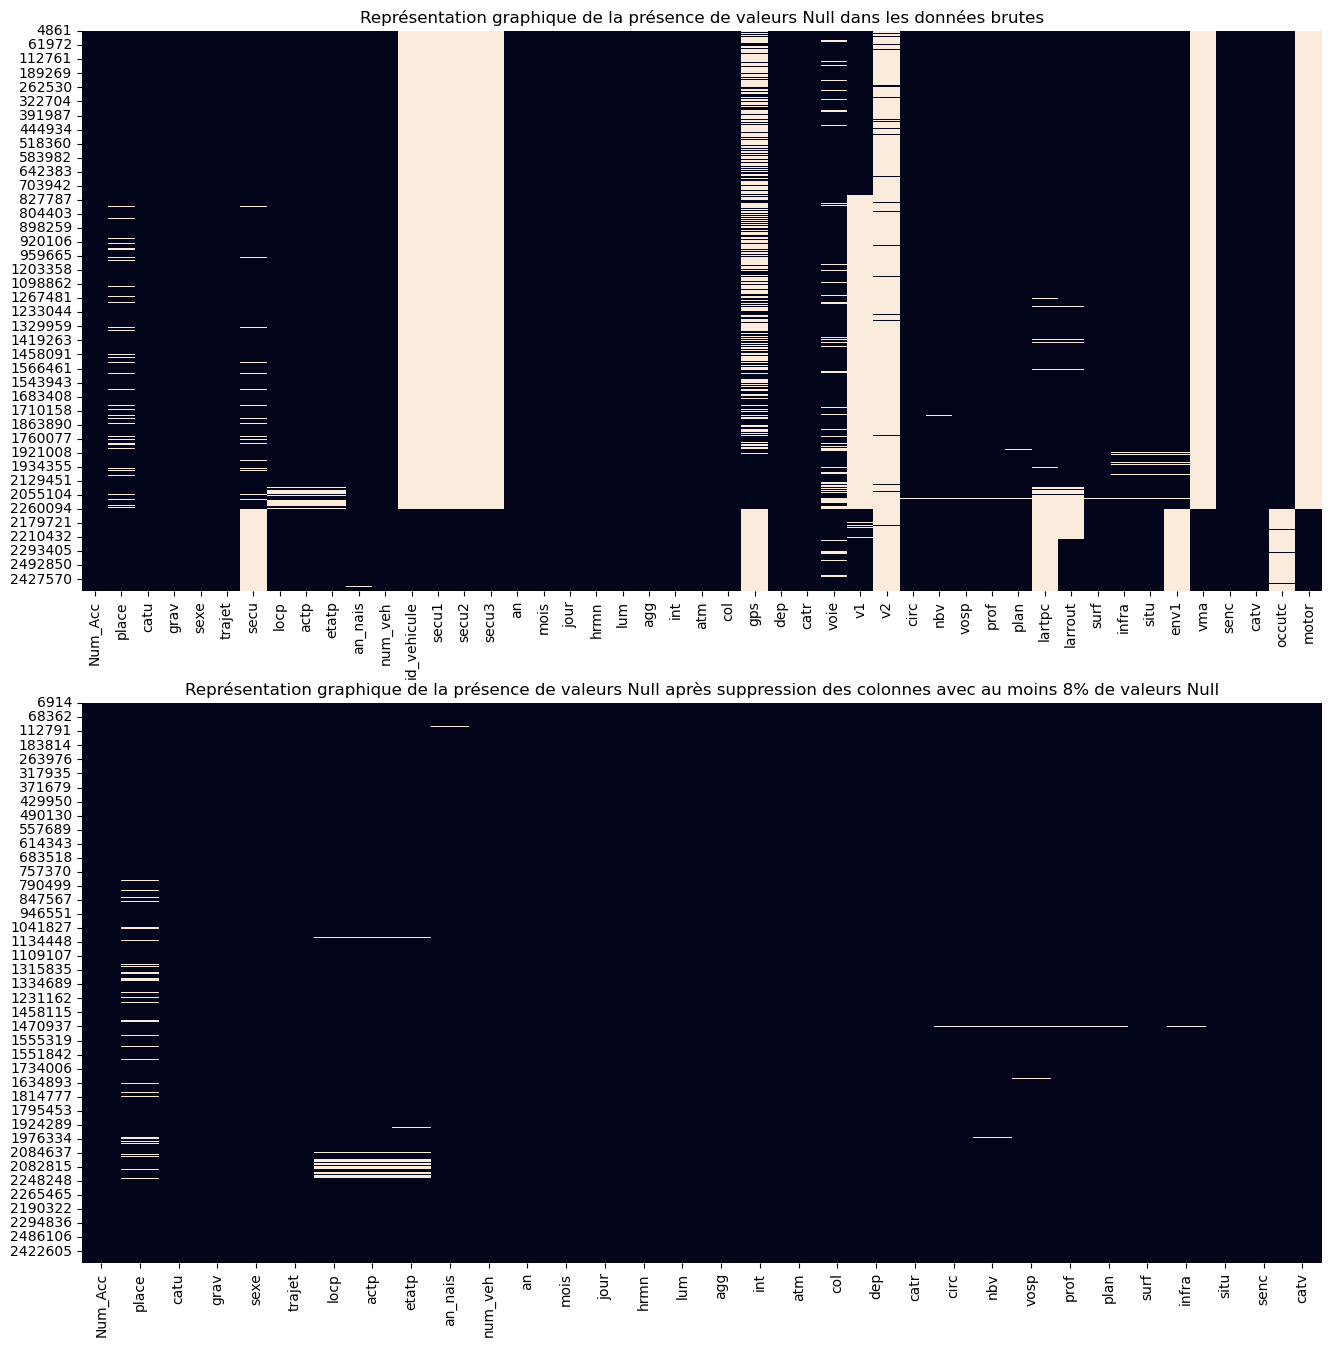

In [4]:
df_sample = df.sample(10000)
df_sample = df_sample.sort_values(by=['an', 'mois', 'jour'], ascending=True)

fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(16, 16)
ax[0].set_title('Représentation graphique de la présence de valeurs Null dans les données brutes')
sns.heatmap(df_sample.isna(), cbar=False, ax=ax[0]);

df = pt.rmv_col_too_much_null(df, 0.08, False)

df_sample = df.sample(10000)
df_sample = df_sample.sort_values(by=['an', 'mois', 'jour'], ascending=True)

ax[1].set_title('Représentation graphique de la présence de valeurs Null après suppression des colonnes avec au moins 8% de valeurs Null')
sns.heatmap(df_sample.isna(), cbar=False, ax=ax[1]);

### Transformation des  *Null* restants en -1 (non renseigné) pour les colonnes qui l'autorisent

In [5]:
df = pt.clean_categ_not_specified(df)

### Nettoyage de l'année de naissance

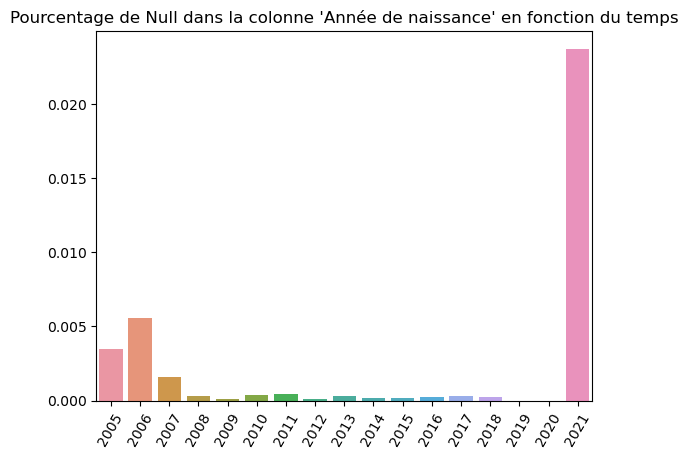

In [6]:
df[df.an_nais.isna()].shape[0]
df[df.an_nais.isna()].an.value_counts()

years = []
rate_nan = []
for year in range(start_year, end_year+1):
    years.append(year)
    rate_nan.append(df[(df.an_nais.isna()) & (df.an==year)].shape[0] / df[df.an==year].shape[0])

plt.title(f"Pourcentage de Null dans la colonne 'Année de naissance' en fonction du temps")
ax = sns.barplot(x=years, y=rate_nan)
plt.xticks(rotation=60);

In [7]:
print("Suppression des lignes avec Null : ")
nb_bef = df.shape[0]
print(f"Nombre de lignes avant : {nb_bef}")

df = df.dropna(axis = 0, how = 'any')
nb_aft = df.shape[0]
print(f"Nombre de lignes après : {nb_aft}")
print(f"Taux de perte : {(nb_bef-nb_aft)/nb_aft*100:.2f} %")

Suppression des lignes avec Null : 
Nombre de lignes avant : 2506762
Nombre de lignes après : 2501286
Taux de perte : 0.22 %


### Création de *age*

In [8]:
df = pt.create_col_age(df)

### Ré-encodeages :*dep*,  *nbv*, *catv*

In [9]:
df = pt.clean_col_dep(df, False)
df = pt.clean_nbv(df)
df = pt.clean_catv(df)

### Affichage des modes des variables catégorielles restantes

In [10]:
# var_categ = df.select_dtypes('Int64').columns
var_categ = df.columns
col_excluded = ['Num_Acc', 'num_veh', 'age', 'hrmn', 'dep', 'an', 'jour', 'an_nais']

for col in var_categ:
    if not (col in col_excluded):
        modes = list(df[col].unique())
        print(f"{col}\t: {modes}")            

place	: [1, 2, 4, 5, 3, 0, 8, 9, 7, 6, -1, 10]
catu	: [1, 2, 3, 4]
grav	: [4, 3, 1, 2]
sexe	: [1, 2, -1]
trajet	: [1, 3, 0, 5, 9, 4, 2, -1]
locp	: [0, 2, 4, 1, 5, 6, 3, 8, 7, -1, 9]
actp	: ['0', '3', '1', '5', '2', '9', '6', '4', -1, ' -1', 'B', 'A', '8', '7']
etatp	: [0, 2, 1, 3, -1]
mois	: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
lum	: [3, 1, 5, 4, 2, -1]
agg	: [2, 1]
int	: [1, 2, 9, 0, 6, 8, 3, 4, 7, 5, -1]
atm	: [1, 2, 3, 8, 9, 7, 6, 4, 5, -1]
col	: [3, 1, 5, 6, 2, 4, 7, -1]
catr	: [3, 2, 4, 6, 9, 5, 1, 7]
circ	: [2, 0, 3, 4, 1, -1]
nbv	: [2, 0, 1, 3, 4, 6, -1, 5]
vosp	: [0, 1, 3, 2, -1]
prof	: [1, 0, 2, 3, 4, -1]
plan	: [1, 3, 2, 0, 4, -1]
surf	: [1, 2, 0, 9, 7, 8, 5, 6, 3, 4, -1]
infra	: [0, 5, 4, 2, 3, 6, 1, 7, -1, 9, 8]
situ	: [1, 5, 3, 4, 0, 2, -1, 6, 8]
senc	: [0, 1, 2, -1, 3]
catv	: [-1, 2, 1, 10, 33]


###  Nettoyage de *hrmn* et création de *date* - *joursem* - *grav_lbl*

In [11]:
df = pt.clean_hrmn(df)

df = pt.create_col_datetime(df)
df = pt.create_col_joursem(df)
df = pt.create_col_grav_lbl(df)

### Suppression des colonnes inutiles : *an_nais*

In [12]:
df = df.drop(columns=['an_nais'], axis=1)

### Analyses croisées

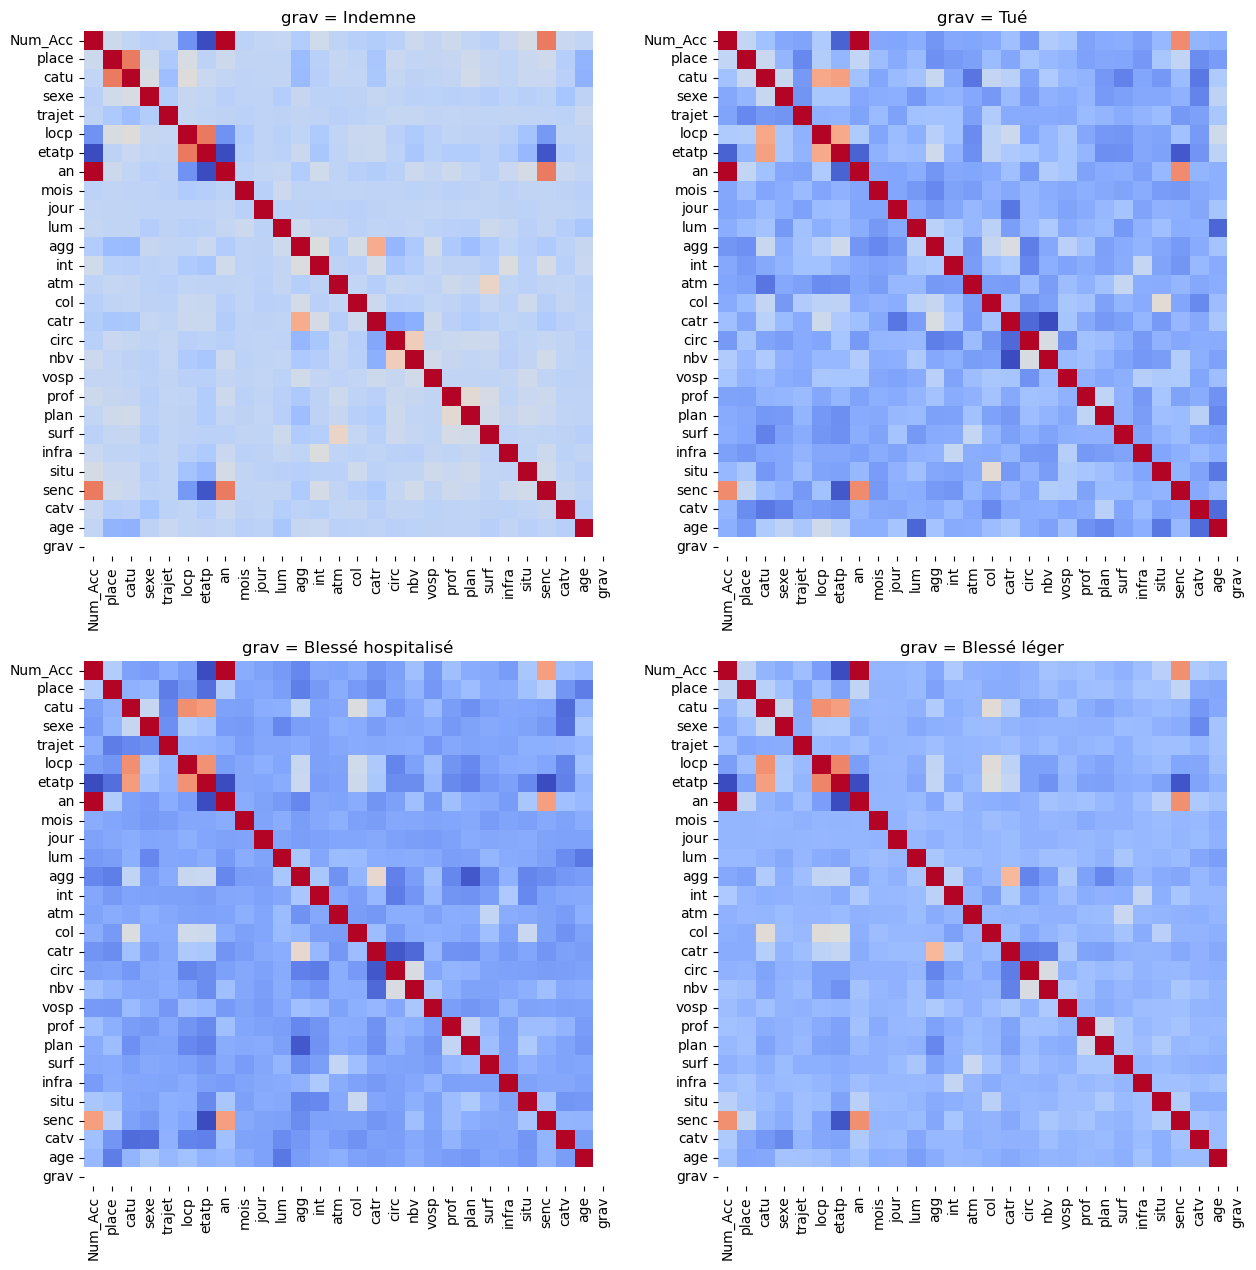

In [13]:
target = df['grav']
data = df.drop(columns=['grav'], axis=1)
# set 'grav' as last column of data
data['grav'] = target

ds = data.sample(10000)
corr1 = ds[ds.grav == 1].corr()

ds = data.sample(10000)
corr2 = ds[ds.grav == 2].corr()

ds = data.sample(10000)
corr3 = ds[ds.grav == 3].corr()

ds = data.sample(10000)
corr4 = ds[ds.grav == 4].corr()

fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15, 15)

axs[0,0].set_title('grav = Indemne')
sns.heatmap(corr1, annot=False, cmap='coolwarm', ax=axs[0,0], cbar=False) 

axs[0,1].set_title('grav = Tué')
sns.heatmap(corr2, annot=False, cmap='coolwarm', ax=axs[0,1], cbar=False) 

axs[1,0].set_title('grav = Blessé hospitalisé')
sns.heatmap(corr3, annot=False, cmap='coolwarm', ax=axs[1,0], cbar=False) 

axs[1,1].set_title('grav = Blessé léger')
sns.heatmap(corr4, annot=False, cmap='coolwarm', ax=axs[1,1], cbar=False);

In [14]:
if False:
    colormap = 'tab20c'
    df_cross = pd.crosstab(df['joursem'], df['grav_lbl'], normalize='index')
    print(df_cross)

    sns.set_theme(style="ticks")
    f, ax = plt.subplots(figsize=(7, 5))
    chart = df_cross.plot(kind="bar", stacked=True, rot=0, ax=ax, 
                          title="Distribution de la gravité en fonction du jour de la semaine", colormap=colormap)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=80)
    sns.move_legend(ax, "upper right")

### Evolution de gravité *Blessé hospitalisé* en 2019?

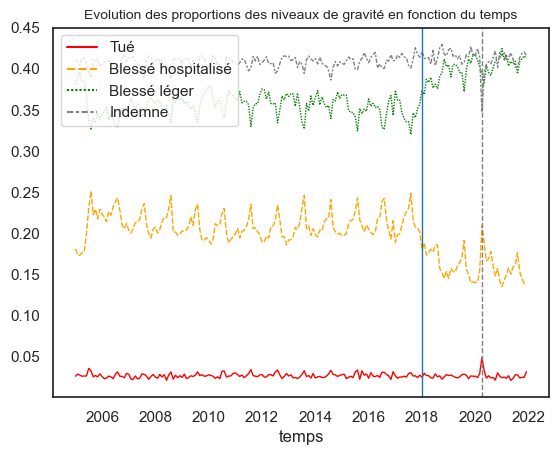

In [15]:
tue     = []
bless_l = []
bless_h = []
indemne = []
y_m     = []
years   = range(start_year, end_year+1)
months  = range(1, 13)

import datetime

df_tmp = df

for year in years:
    for month in months:
#         df_tmp = df[(df.datetime.dt.year == year) & (df.datetime.dt.month == month)]
        df_tmp = df[(df.an==year) & (df.mois==month)]
        if 2 in df_tmp.grav.value_counts(normalize=True).index: 
            tue.append(df_tmp.grav.value_counts(normalize=True)[2]) 
        else :
            tue.append(tue[-1])
        if 3 in df_tmp.grav.value_counts(normalize=True).index: 
            bless_h.append(df_tmp.grav.value_counts(normalize=True)[3])
        else:
            bless_h.append(bless_h[-1])
        if 4 in df_tmp.grav.value_counts(normalize=True).index: 
            bless_l.append(df_tmp.grav.value_counts(normalize=True)[4])
        else:
            bless_l.append(bless_l[-1])
        if 1 in df_tmp.grav.value_counts(normalize=True).index: 
            indemne.append(df_tmp.grav.value_counts(normalize=True)[1])
        else:
            indemne.append(indemne[-1])
        y_m.append(datetime.datetime(year, month, 1))

  
data = pd.DataFrame({'Tué':tue, 'Blessé hospitalisé':bless_h, 'Blessé léger':bless_l, 'Indemne':indemne, 'temps':y_m})
data = data.set_index('temps')

sns.set_theme(style="white", palette=None)
ax = sns.lineplot(data=data, palette=['red','orange','green','gray'], linewidth=1) #.set_title("Evolution des proportions des niveaux de gravité en fonction du temps")
ax.axes.set_title("Evolution des proportions des niveaux de gravité en fonction du temps",fontsize=10)

plt.axvline(datetime.datetime(2018, 1, 1), linewidth=1)
plt.axvline(datetime.datetime(2020, 4, 1), linestyle='--', color='gray', linewidth=1)
plt.legend(loc='upper left');

In [ ]:
df_cross = pd.crosstab(df['place'], df['grav_lbl'], normalize='index')
df_cross = df_cross.reindex(columns=columns_titles)
print(df_cross)

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
chart = df_cross.plot(kind="bar", stacked=True, rot=0, ax=ax, 
                         title="Distribution de la gravité en fonction de la place de l'usager", colormap=colormap)
chart.set_xticklabels(chart.get_xticklabels(), rotation=80)
sns.move_legend(ax, "upper right")

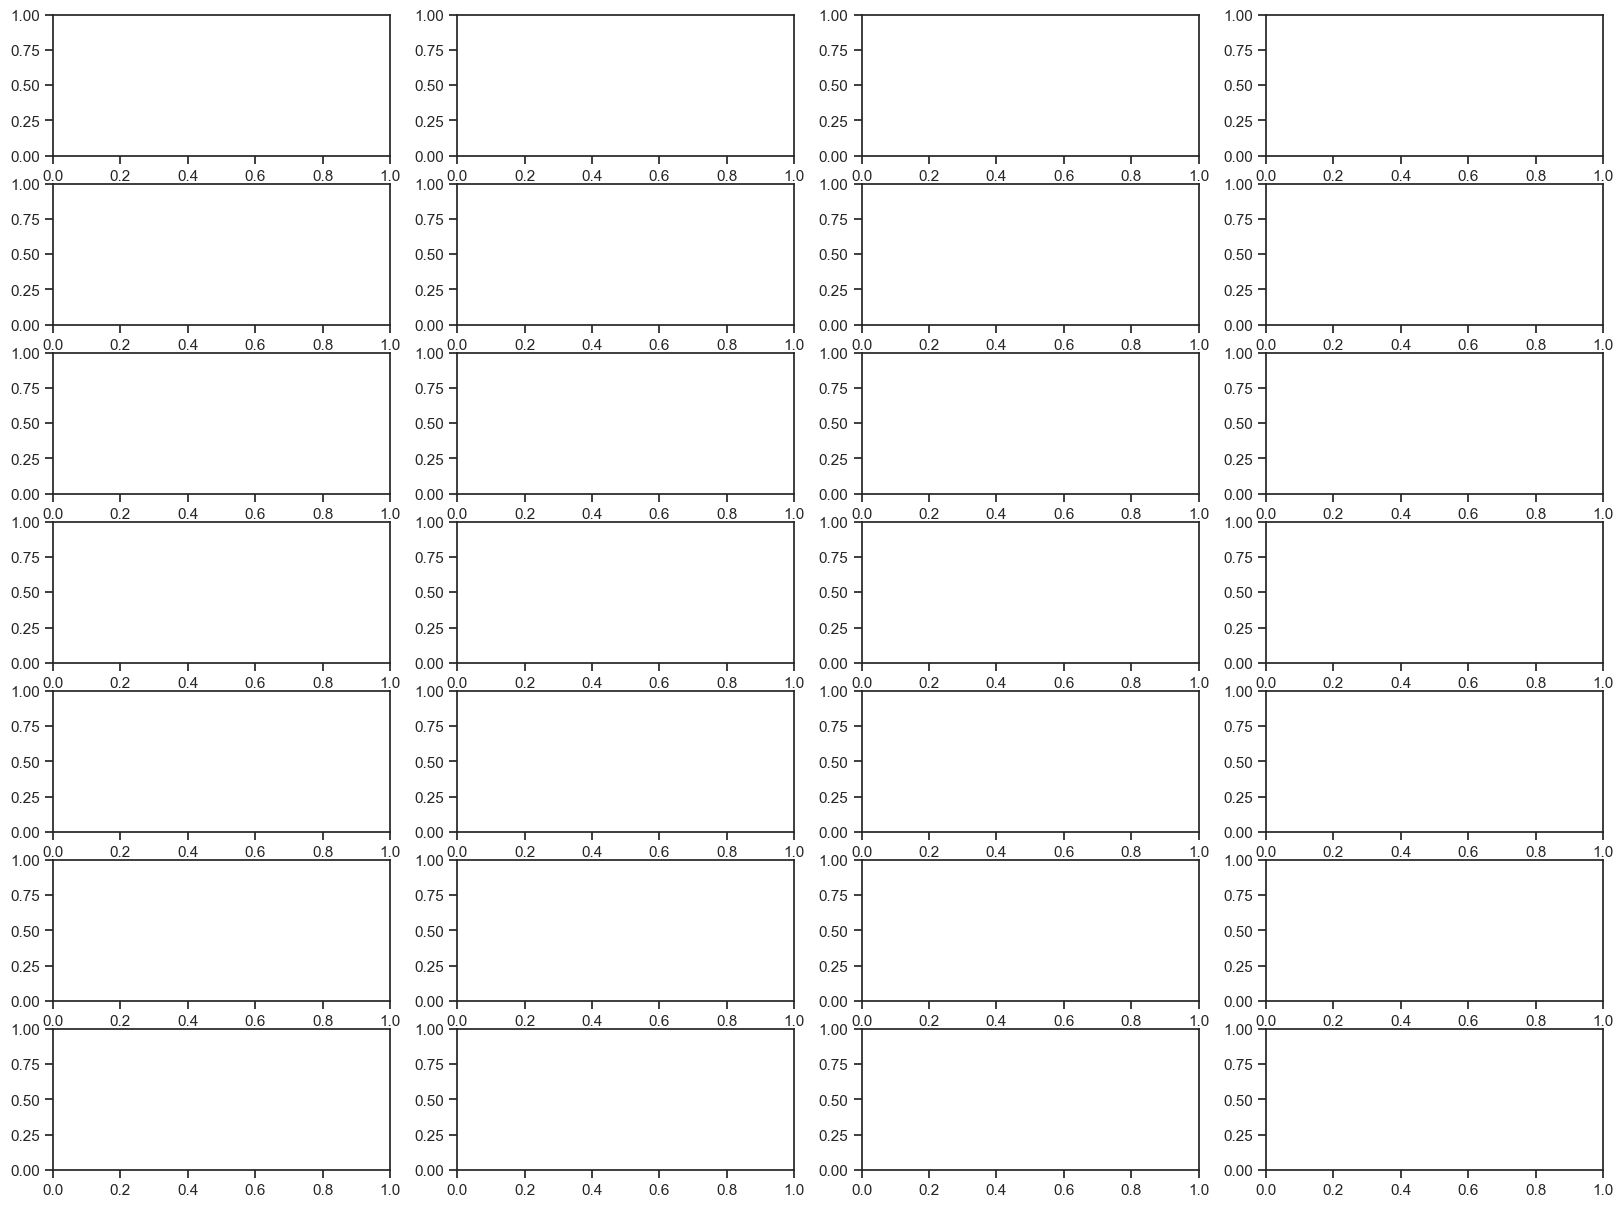

0
1


In [59]:
colormap = 'tab20c'
col = 'place'

col_excluded = ['Num_Acc', 'num_veh', 'age', 'hrmn', 'dep', 'an', 'jour', 'an_nais']

sns.set_theme(style="ticks")
fig, axs = plt.subplots(7,4)
fig.set_size_inches(20, 15)
axs = np.reshape(axs, -1)
plt.show()

k = 0
for col in df.columns:
    if not (col in col_excluded) and (k <= 1):    
#         if (k%5 == 0) : 
        print(k)
        df_cross = pd.crosstab(df[col], df.grav_lbl, normalize='index')
        chart = df_cross.plot(kind="bar", stacked=True, rot=0, ax=axs[k], title=f"{col}", colormap=colormap)
#         axs[k].yaxis.set_visible(False)
#         chart.set_xticklabels(chart.get_xticklabels(), rotation=80)        
        k += 1

In [23]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2501286 entries, 0 to 2506761
Data columns (total 35 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Num_Acc   2501286 non-null  int64         
 1   place     2501286 non-null  Int64         
 2   catu      2501286 non-null  Int64         
 3   grav      2501286 non-null  Int64         
 4   sexe      2501286 non-null  Int64         
 5   trajet    2501286 non-null  Int64         
 6   locp      2501286 non-null  Int64         
 7   actp      2501286 non-null  object        
 8   etatp     2501286 non-null  Int64         
 9   num_veh   2501286 non-null  object        
 10  an        2501286 non-null  Int64         
 11  mois      2501286 non-null  Int64         
 12  jour      2501286 non-null  Int64         
 13  hrmn      2501286 non-null  object        
 14  lum       2501286 non-null  Int64         
 15  agg       2501286 non-null  Int64         
 16  int       2501286 

In [17]:
# vc = df.joursem.value_counts()
# xlabels = ['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche']
# heights = [vc[label] for label in xlabels]

# plt.bar(x=xlabels, height=heights)